**Autor**: Samuel Soutullo Sobral

# Práctica 1: paralelismo cuántico

Utiliza el paralelismo cuántico para evaluar una función $f(x) = f(\{x_{n-1},x_{n-2},\ldots,x_0\}) \rightarrow \{0,1\}$, con $x_i \in \{0,1\}$, que verifique:

$$
f(x) = 
\begin{cases}
1, \text{si } x \text{ es par}\\
0, \text{si } x \text{ es impar}\\
\end{cases}
$$

Crea un circuito en Qiskit para $n=2$.

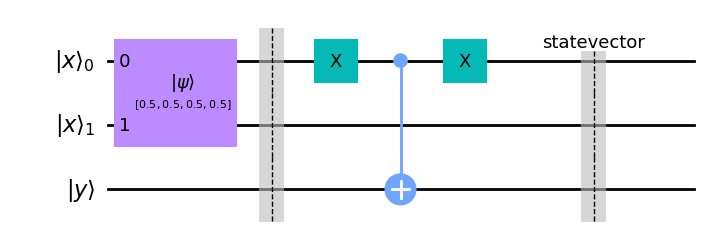

<IPython.core.display.Latex object>

In [1]:
import numpy as np
from qiskit.circuit.library import MCMT
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, execute, ClassicalRegister
from qiskit.providers.aer import AerSimulator

x = QuantumRegister(2, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x, y)

plus_state = Statevector.from_label('++')
qc.initialize(plus_state, x)
qc.barrier()

qc.x(x[0])
qc.cx(x[0], y)
qc.x(x[0])
qc.save_statevector()

display(qc.draw('mpl'))

job_sim = execute(qc, AerSimulator(), shots=1)
result = job_sim.result()
state = result.get_statevector()

array_to_latex(state, prefix="|\\psi\\rangle =")

Se trata del estado:

$|\psi\rangle = \frac{1}{\sqrt{2}}(|001\rangle + |011\rangle + |100\rangle + |110\rangle) = \frac{1}{\sqrt{2}}(|f(01), 01\rangle + |f(11), 11\rangle + |f(00), 00\rangle + |f(10), 10\rangle)$

------------------------------
------------------------------
------------------------------

# Práctica 2: algoritmo de  Deutsch-Jozsa 

Implementa en Qiskit el algoritmo de Deutsch-Jozsa para un $n$ arbitrario.

Pasos:

1. Crea una función que devuelva un oráculo para $f$ constante.

In [2]:
def cte_oraculo(n):
    """
    Define un oraculo para una función constante de n bits
        return: circuito de n+1 cúbits en forma de puerta
    """
    qc = QuantumCircuit(n+1)
    qc.x(n)
    
    return qc

2. Crea una función que devuelva un oráculo para $f$ balanceada.

In [3]:
def bal_oraculo(n):
    """
    Define un oraculo para una función balanceada de n bits
        return: circuito de n+1 cúbits en forma de puerta
    """
    qc = QuantumCircuit(n+1)
    qc.cx(0, n)
    
    return qc

3. Crea una función que devuelva una puerta oráculo cte. o balanceado según un parámetro de entrada

In [4]:
def dj_oraculo(n, tipo):
    """
    Devuelve un oraculo para el algoritmo de Deutsch-Jozsa
    
        n: Número de cúbits de entrada
        tipo: tipo de oráculo, 0 cte., 1 balanceado
        return: circuito de n+1 cúbit en forma de puerta
    """
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)
    
    if tipo == 0:
        qc = qc.compose(cte_oraculo(n))
    elif tipo == 1:
        qc = qc.compose(bal_oraculo(n))
    else:
        raise ValueError("El tipo de oráculo debe ser 0 (constante) o 1 (balanceado)")
    
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f}$"
    
    return oraculo

4. Implementa paso a paso el circuito completo del algoritmo de Deutsch-Jozsa:

Paso 0: Obtén el estado inicial:
        
$$\vert \psi_0 \rangle = \vert 1\rangle\vert0\rangle^{\otimes n} $$

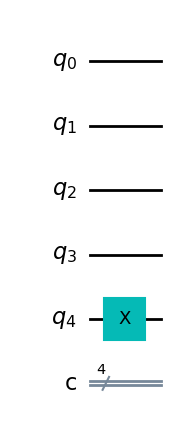

In [5]:
def paso_0(n):
    qc = QuantumCircuit(n+1,n)
    qc.x(n)
    
    return qc

# Mostramos el circuito
n = 4
paso_0(n).draw('mpl')

Paso 1: Obtén el estado 
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \left(|0\rangle - |1 \rangle \right)\vert x\rangle $$

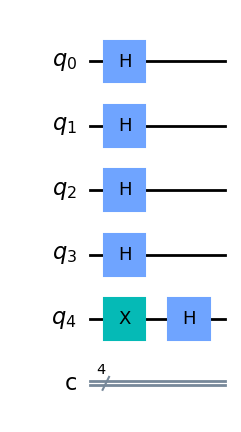

In [6]:
def paso_1(n):
    qc = paso_0(n)
    qc.h(range(n+1))
    
    return qc

# Mostramos el circuito
paso_1(n).draw('mpl')

Paso 2: Añadimos el oráculo para obtener:
$$
            \lvert \psi_2 \rangle  
                 = \frac{|0\rangle - |1\rangle}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle  
        $$

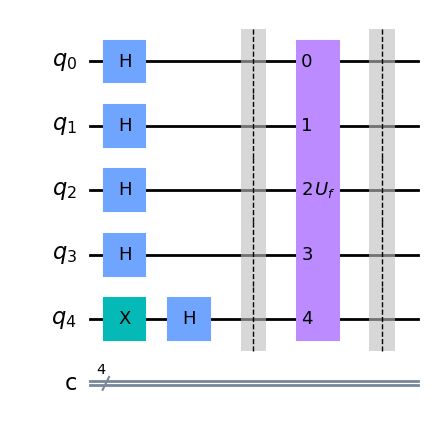

In [7]:
def paso_2(n, tipo_oraculo):
    qc = paso_1(n)
    
    # Añadimos barreras para una mejor visualización
    qc.barrier()
    qc = qc.compose(dj_oraculo(n, tipo_oraculo))
    qc.barrier()
    
    return qc

# Mostramos el circuito
paso_2(n, 1).draw('mpl')

Paso 3: Añade las últimas puertas H y la medida de los $n$ primeros cúbits.

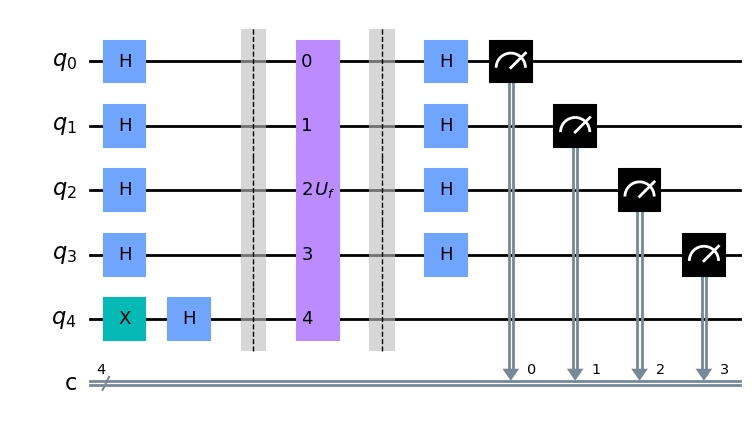

In [8]:
def paso_3(n, tipo_oraculo):
    qc = paso_2(n, tipo_oraculo)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    
    return qc

# Selecciona un oráculo aleatorio
tipo_oraculo = np.random.randint(2)
dj_circuito = paso_3(4, tipo_oraculo)
dj_circuito.draw('mpl')

Simulamos el circuito y obtenemos un histograma de la salida:

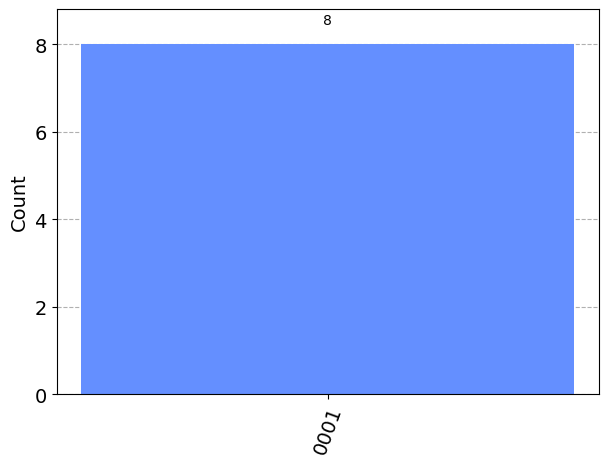

In [9]:
# Usamos un simulador local
sim = AerSimulator()
result = execute(dj_circuito, sim, shots = 8).result()
salida = result.get_counts()
plot_histogram(salida)

Verifica que si el oráculo es constante, la salida es 0, y si es balanceado es $\ne 0$.

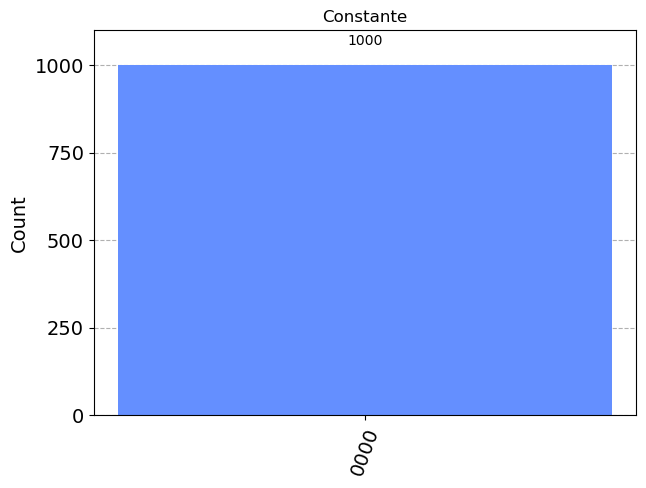

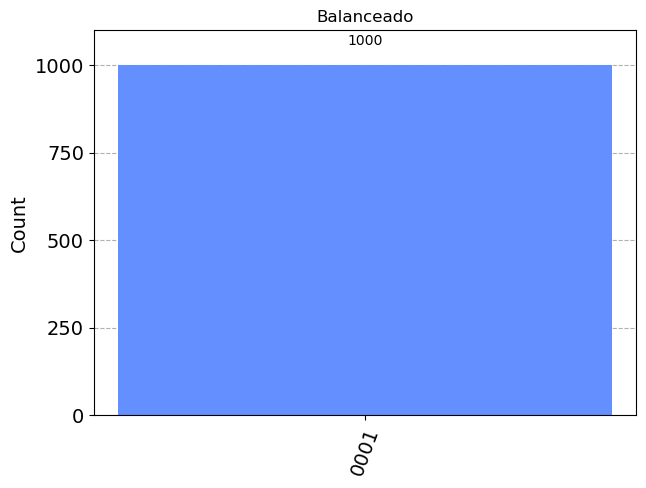

In [10]:
constant_qc = paso_3(4, 0)
balanced_qc = paso_3(4, 1)

display(plot_histogram(execute(constant_qc, sim, shots=1000).result().get_counts(), title="Constante"))
display(plot_histogram(execute(balanced_qc, sim, shots=1000).result().get_counts(), title="Balanceado"))

Como se puede ver, la salida es siempre $0000 = 0$ para la función constante y $0001 = 1 \neq 0$ para la función balanceada.

-----------------------------
-----------------------------
-----------------------------

# Práctica 3: algoritmo de Bernstein-Vazirani 

Implementa en Qiskit el algoritmo de Bernstein-Vazirani para un $n$ y un $s$ con el oráculo implementado en el ejercicio 5.

Obtén la salida y comprueba que puede encontrar el valor de $s$.

In [11]:
def as_bit_array(x, n):
    """Función auxiliar para convertir un entero en un array de bits de longitud n"""
    return [int(i) for i in list(np.binary_repr(x, width=n))]

In [12]:
def bv_oraculo(n, s):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)
    
    sinv = s[::-1]
    
    for q in range(n):
        if sinv[q] == 1:
            qc.cx(q,n)
            
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f}$"
    
    return oraculo

**Ejemplo**: visualizamos el oráculo para $n=4$ y $s=3$:

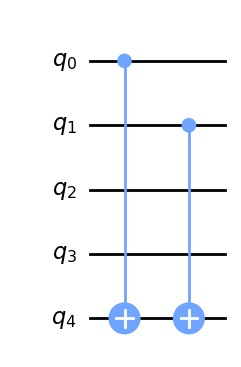

In [13]:
n = 4
s = 3

QuantumCircuit(n+1).compose(bv_oraculo(n, as_bit_array(s, n))).decompose().draw('mpl')

Genero todos los posibles valores de $s$ para $n=4$:

In [14]:
n = 4
s_values = [as_bit_array(i, n) for i in range(2**n)]

print(s_values)

[[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]


Visualizamos el circuito para $s=0$ (realmente solo cambia el oráculo para distintos valores de $s$):

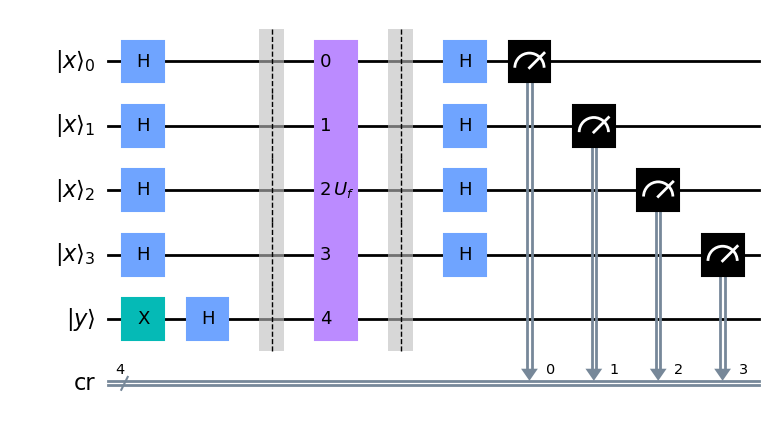

In [15]:
def bv_circuito(n, s):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    cr = ClassicalRegister(n, name="cr")
    qc = QuantumCircuit(x, y, cr)
    
    qc.x(n)
    qc.h(range(n+1))
    qc.barrier()
    qc = qc.compose(bv_oraculo(n, s))
    qc.barrier()
    qc.h(range(n))
    qc.measure(x, cr)
    
    return qc

bv_circuito(n, s_values[0]).draw('mpl')

Simulamos el circuito para todos los valores de $s$ y verificamos que la salidas son correctas:

In [16]:
for s in s_values:
    print(f"s = {s}, salida = {execute(bv_circuito(n, s), sim, shots=1000).result().get_counts()}")

s = [0, 0, 0, 0], salida = {'0000': 1000}
s = [0, 0, 0, 1], salida = {'0001': 1000}
s = [0, 0, 1, 0], salida = {'0010': 1000}
s = [0, 0, 1, 1], salida = {'0011': 1000}
s = [0, 1, 0, 0], salida = {'0100': 1000}
s = [0, 1, 0, 1], salida = {'0101': 1000}
s = [0, 1, 1, 0], salida = {'0110': 1000}
s = [0, 1, 1, 1], salida = {'0111': 1000}
s = [1, 0, 0, 0], salida = {'1000': 1000}
s = [1, 0, 0, 1], salida = {'1001': 1000}
s = [1, 0, 1, 0], salida = {'1010': 1000}
s = [1, 0, 1, 1], salida = {'1011': 1000}
s = [1, 1, 0, 0], salida = {'1100': 1000}
s = [1, 1, 0, 1], salida = {'1101': 1000}
s = [1, 1, 1, 0], salida = {'1110': 1000}
s = [1, 1, 1, 1], salida = {'1111': 1000}


Las salidas son correctas, ya que para cada $s$ la salida es $s$ con un 100% de probabilidad.

-----------------------------
-----------------------------
-----------------------------

# Práctica 4: algoritmo de Simon

Implementa en Qiskit el algoritmo de Simon para un $n$ y un $c$ arbitrario y el oráculo simple que hemos visto.

Empieza implementando el oráculo como una puerta. 

Para probarlo, supón $n=3$ y $c$ un valor aleatorio en el intervalo $[0,7]$. Obtén el valor de $c$ a partir de la salida del algoritmo. 

In [17]:
def simon_oracle(n, c):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(n, name="|y\\rangle")
    qc = QuantumCircuit(x, y)
    
    qc.cx(x, y)
    
    if c != 0:
        c_bits = as_bit_array(c, n)
        c_bits_rev = c_bits[::-1]
        lsb1_index = c_bits_rev.index(1)
        
        for j in range(lsb1_index, n):
            if c_bits_rev[j] == 1:
                qc.cx(x[lsb1_index], y[j])
    
    return qc.to_gate(label="$U_{f}$")

**Ejemplo**: visualizamos el oráculo para $n=3$ y $c=3$:

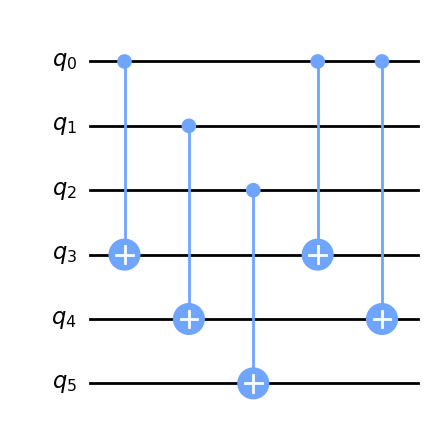

In [18]:
n = 3
c = 3

QuantumCircuit(2*n).compose(simon_oracle(n, c)).decompose().draw('mpl')

In [19]:
def find_c_from_simon(n, results):    
    for possible_c in range(1, 2**n):
        possible_c_bits = as_bit_array(possible_c, n)

        # Verificamos si todos los resultados satisfacen la condición (producto escalar modulo 2 con c_bits = 0)
        if all([np.dot(possible_c_bits, [int(i) for i in result]) % 2 == 0 for result in results]):
            return possible_c

    return 0

Posibles medidas = ['110', '000', '111', '001']
c = 6, c (Simon) = 6


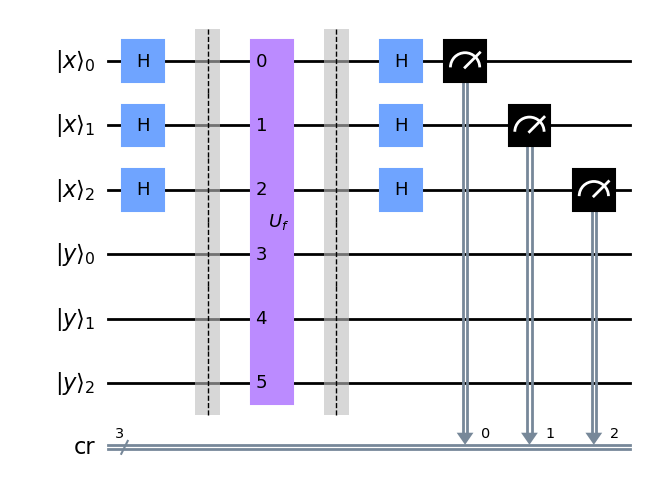

In [20]:
n = 3
c = np.random.randint(0, 2**n)

x = QuantumRegister(n, name="|x\\rangle")
y = QuantumRegister(n, name="|y\\rangle")
cr = ClassicalRegister(n, name="cr")
simon_qc = QuantumCircuit(x, y, cr)

simon_qc.h(x)
simon_qc.barrier()
simon_qc = simon_qc.compose(simon_oracle(n, c))
simon_qc.barrier()
simon_qc.h(x)
simon_qc.measure(x, cr)

results = list(execute(simon_qc, sim, shots=1000).result().get_counts().keys())
print(f"Posibles medidas = {results}")

c_simon = find_c_from_simon(n, results)
print(f"c = {c}, c (Simon) = {c_simon}")

simon_qc.draw('mpl')

--------------------
-------------------
------------------

# Práctica 5: algoritmo de Grover

Implementa en Qiskit el algoritmo de Grover para para un número arbitrario de cúbits.

In [21]:
def grover_oracle(n, s):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x, y)
        
    temp = s
    for b in range(n):
        if temp&1 == 0:
            qc.x(b)
        temp >>= 1
            
    qc.mcx(x, y)
    
    temp = s
    for b in range(n):
        if temp&1 == 0:
            qc.x(b)
        temp >>= 1
    
    return qc

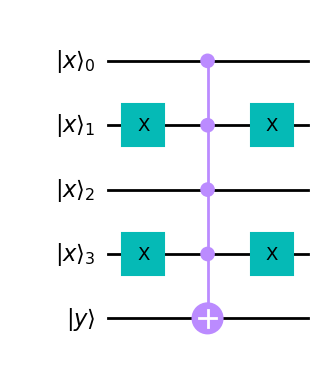

In [22]:
grover_oracle(4, 5).draw('mpl')

In [23]:
def amplitude_amplification(n):
    x = QuantumRegister(n, name="|x\\rangle")
    qc = QuantumCircuit(x)
        
    qc.h(x)
    
    qc.x(x)
    qc = qc.compose(MCMT('z', n - 1, 1))
    qc.x(range(n-1))
    
    qc.z(n-1)
    qc.x(n-1)
    qc.z(n-1)
    
    qc.h(x)
    
    return qc

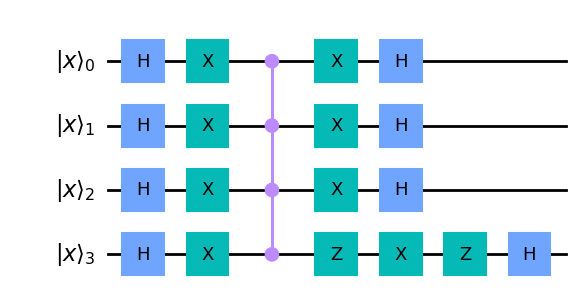

In [24]:
amplitude_amplification(4).draw('mpl')

In [25]:
def grover_circuit(n, s):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    cr = ClassicalRegister(n, name="cr")
    qc = QuantumCircuit(x, y, cr)
    
    qc.h(x)
    qc.x(y)
    qc.h(y)
    qc.barrier()
    
    repetitions = np.pi/4 * np.sqrt(2**n)
    repetitions = int(np.floor(repetitions))
    
    for _ in range(repetitions):
        qc = qc.compose(grover_oracle(n, s))
        qc.barrier()
        qc = qc.compose(amplitude_amplification(n))
        qc.barrier()
    
    qc.measure(x, cr)
    
    return qc

**Ejemplo**: visualizamos el circuito completo para $n=2$ y $s=1$:

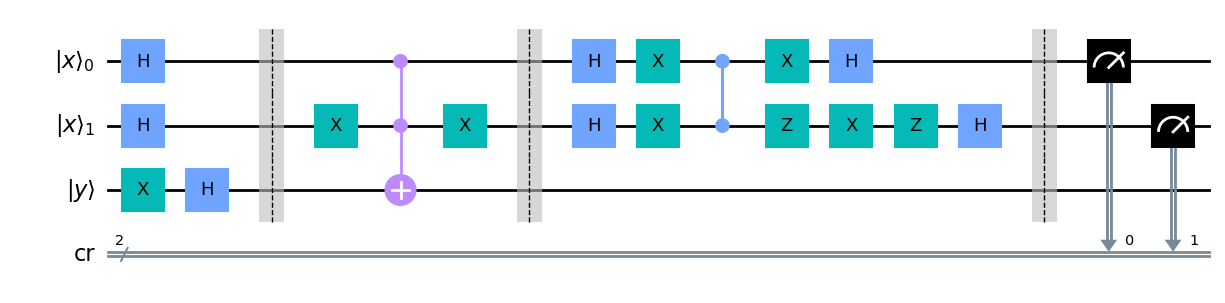

In [26]:
grover_circuit(2, 1).draw('mpl')

**Ejemplo**: visualizamos el circuito completo para $n=3$ y $s=2$, se puede apreciar que el número de repeticiones es 2:

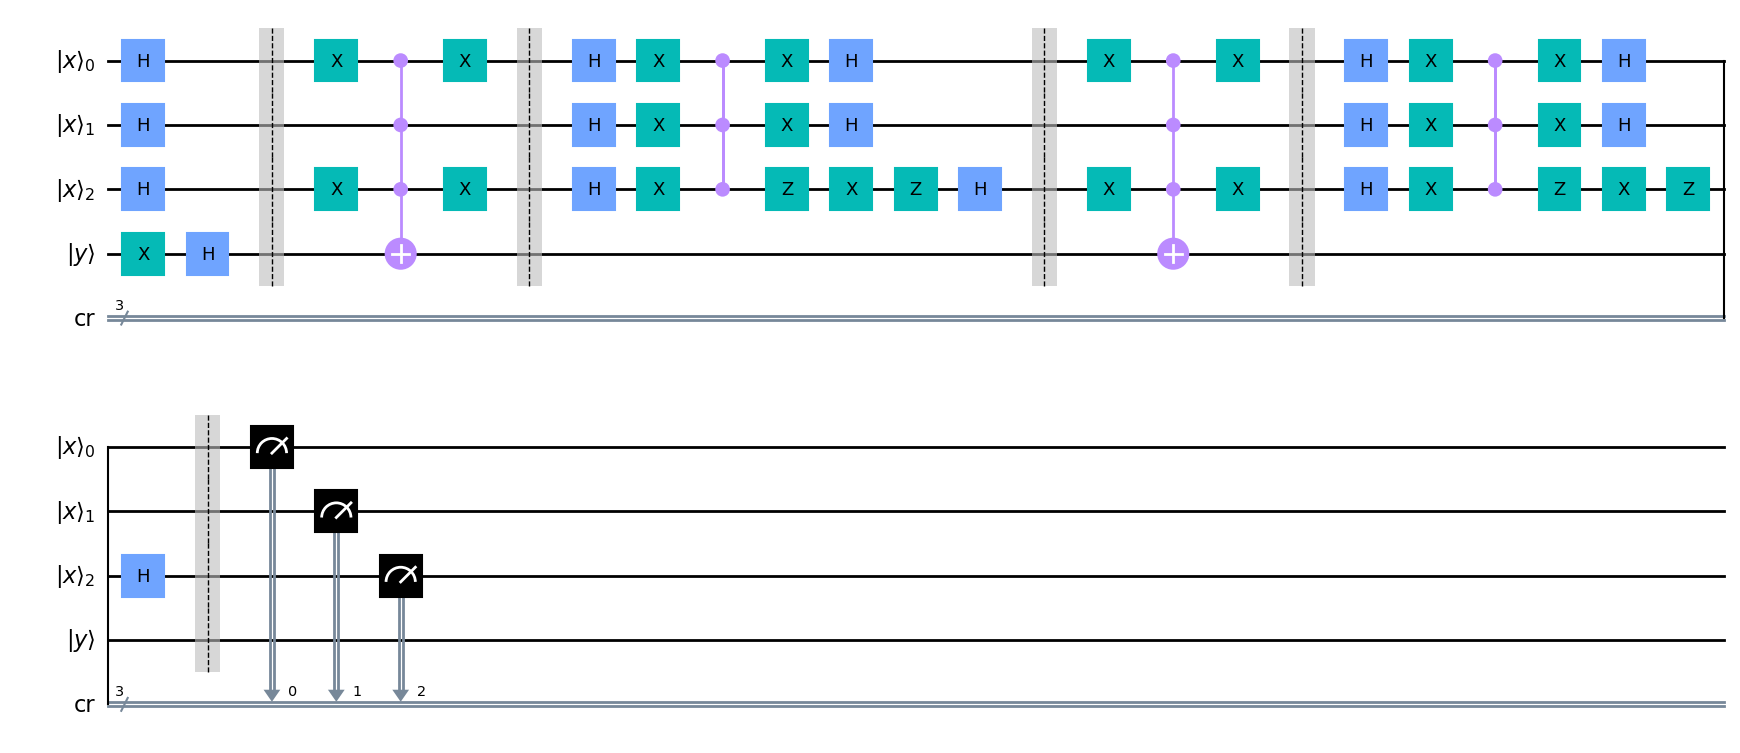

In [27]:
grover_circuit(3, 2).draw('mpl')

Simulamos el circuito para varios valores de $n$ y $s$ y verificamos que se obtiene la salida correcta con probabilidad muy alta:

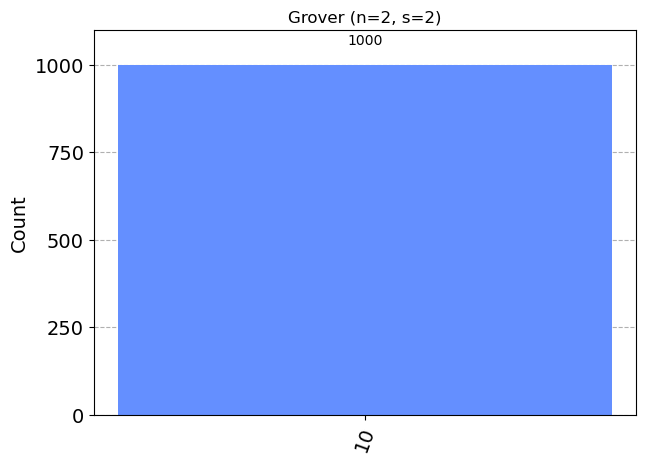

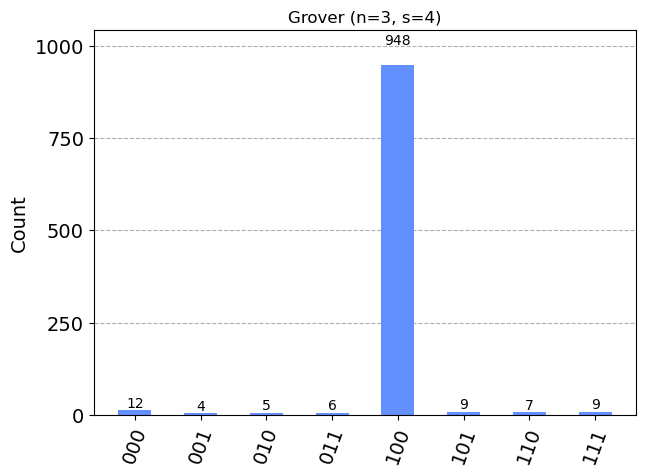

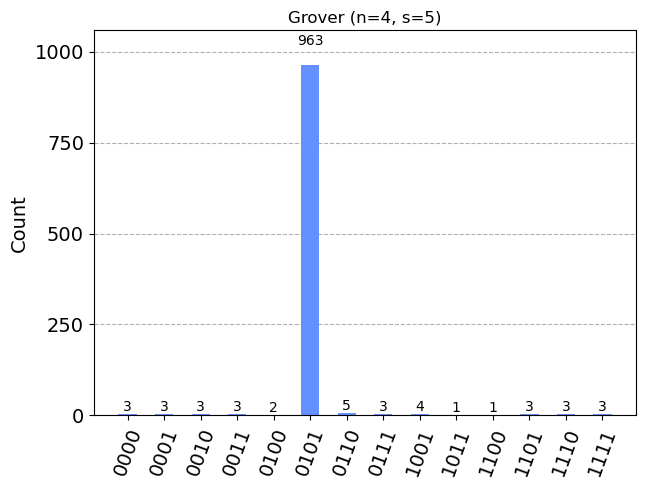

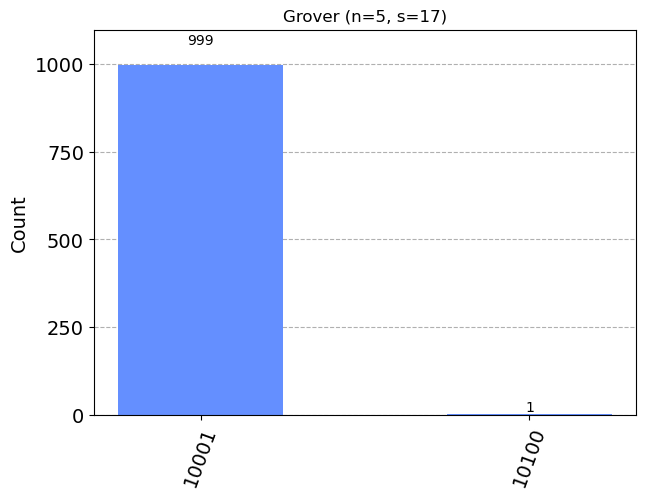

In [28]:
for n in range(2, 6):
    s = np.random.randint(0, 2**n)
    results = execute(grover_circuit(n, s), sim, shots=1000).result().get_counts()
    
    display(plot_histogram(results, title=f"Grover (n={n}, s={s})"))

La siguiente celda imprime la salida más probable del algoritmo de Grover para unos valores de $n$ y $s$ arbitrarios:

In [29]:
n = 4
s = 5

results = execute(grover_circuit(n, s), sim, shots=1000).result().get_counts()
results_sorted = sorted(results.items(), key=lambda item: item[1], reverse=True)

print(f"s (Grover) = {results_sorted[0][0]}")

s (Grover) = 0101


También se puede generalizar el algoritmo de Grover para encontrar más de un valor de $s$.

In [30]:
def grover_oracle_multi(n, s):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x, y)
    
    for s_i in s:
        temp = s_i
        for b in range(n):
            if temp&1 == 0:
                qc.x(b)
            temp >>= 1
                
        qc.mcx(x, y)
        
        temp = s_i
        for b in range(n):
            if temp&1 == 0:
                qc.x(b)
            temp >>= 1
    
    return qc

In [31]:
def grover_circuit_multi(n, s):
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    cr = ClassicalRegister(n, name="cr")
    qc = QuantumCircuit(x, y, cr)
    
    qc.h(x)
    qc.x(y)
    qc.h(y)
    qc.barrier()
    
    repetitions = np.pi/4 * np.sqrt(2**n / len(s))
    repetitions = int(np.floor(repetitions))
    
    for _ in range(repetitions):
        qc = qc.compose(grover_oracle_multi(n, s))
        qc.barrier()
        qc = qc.compose(amplitude_amplification(n))
        qc.barrier()
    
    qc.measure(x, cr)
    
    return qc

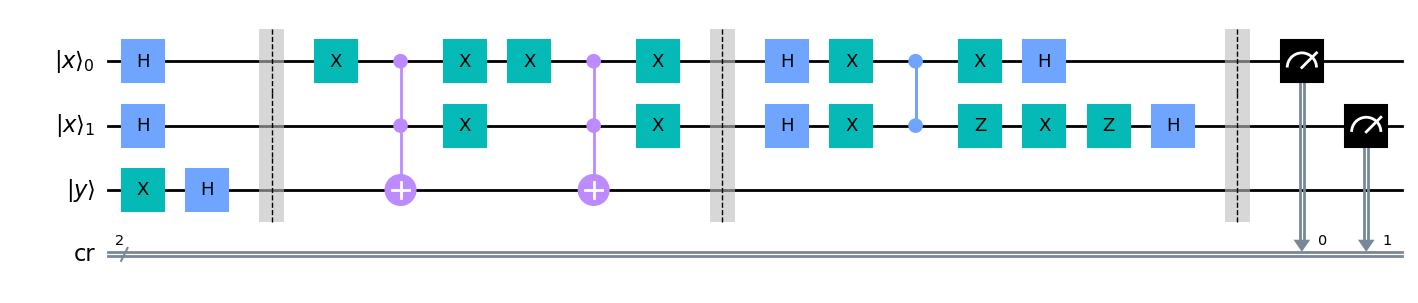

In [32]:
grover_circuit_multi(2, [2, 0]).draw('mpl')

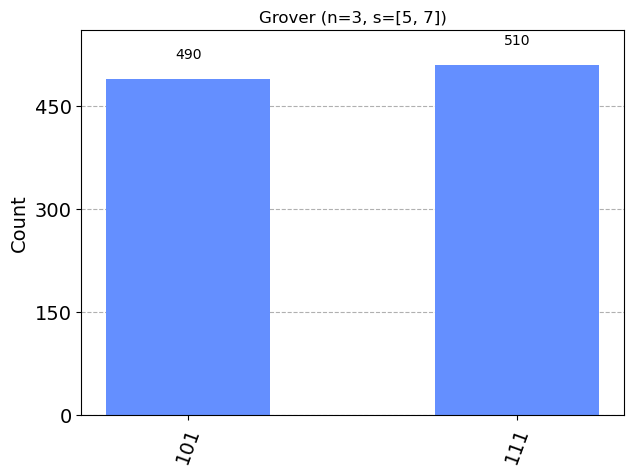

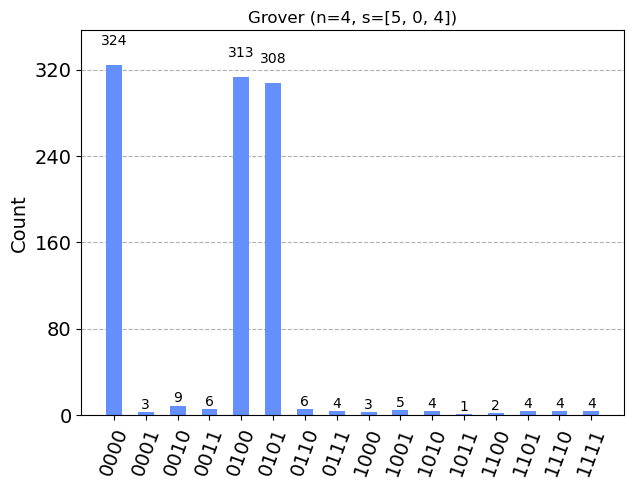

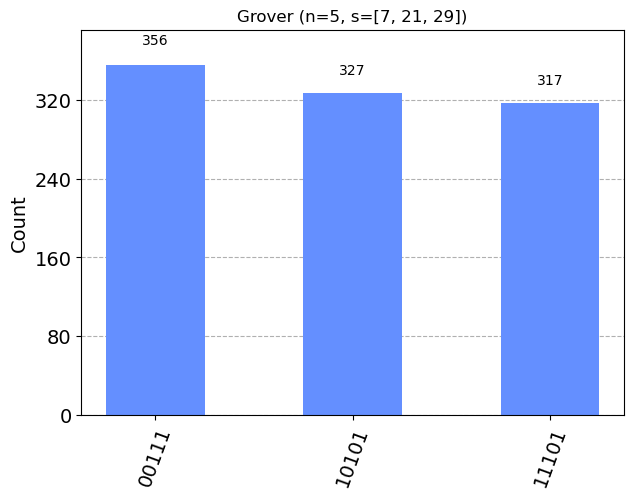

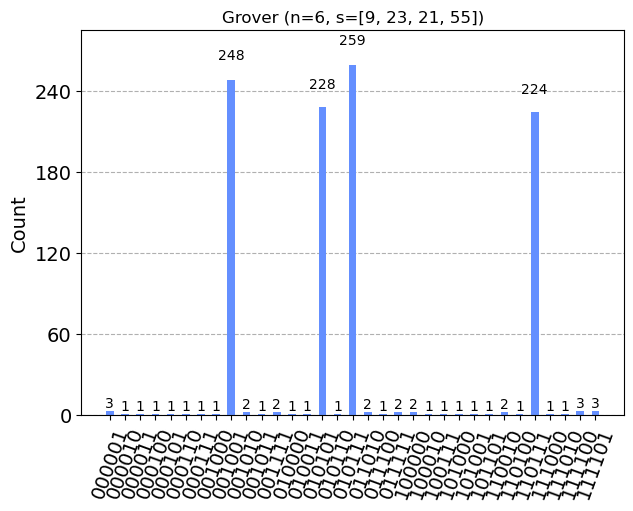

In [33]:
for n in range(3, 7):
    s = [np.random.randint(0, 2**n) for _ in range(n//2 + 1)]
    results = execute(grover_circuit_multi(n, s), sim, shots=1000).result().get_counts()
    
    display(plot_histogram(results, title=f"Grover (n={n}, s={s})"))